# Evaluation notebooks

### First, load the data first

100%|██████████| 206/206 [01:51<00:00,  1.85it/s]

Total DBZ maps processed: 206. Shape of each DBZ map: (505, 1220)
----------------------------------------


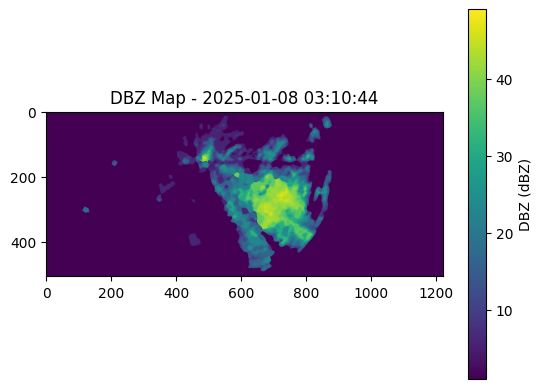

In [48]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

from src.utils import windy_preprocessing_pipeline, process_image

SOURCE_PATH = "data/images/philippines"
img_paths = [os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')]

dbz_maps: list[tuple[np.ndarray, datetime]] = []

for img_path in tqdm(img_paths):
    img, time_frame = process_image(img_path)
    dbz_map = windy_preprocessing_pipeline(img)
    dbz_maps.append((dbz_map, time_frame))

print(f"Total DBZ maps processed: {len(dbz_maps)}. Shape of each DBZ map: {dbz_maps[0][0].shape}")
print("-"*40)

# Visualize first DBZ map
plt.imshow(dbz_maps[0][0], cmap='viridis')
plt.colorbar(label='DBZ (dBZ)')
plt.title(f"DBZ Map - {dbz_maps[0][1]}")
plt.show()

## Identify storms first

In [49]:
# import sys

# for k in list(sys.modules.keys()):
#     if k.startswith('src.'):
#         del sys.modules[k]
#         print(f"Deleted module: {k}")

In [61]:
import cv2

from src.cores.base import StormsMap
from src.model.etitan_original import ETitanPrecipitationModel
from src.model.titan_original import TitanPrecipitationModel
from src.identification import MorphContourIdentifier, SimpleContourIdentifier

from src.cores.movement_estimate import TREC, MTREC, COTREC

DBZ_THRESHOLD = 35  # dBZ
FILTER_AREA = 50  # pixels      ==> Less than 50 pixels will be filtered out

actual_active_maps = [(dbz_map >= DBZ_THRESHOLD, time_frame) for dbz_map, time_frame in dbz_maps]

### Select identifier
identifier = SimpleContourIdentifier()
model = TitanPrecipitationModel(identifier=identifier, max_velocity=500)

# identifier = MorphContourIdentifier(n_thresh=3, center_filter=10)
# model = ETitanPrecipitationModel(identifier=identifier, trec=COTREC())

storms_maps: list[StormsMap] = []

for idx, (dbz_map, time_frame) in tqdm(list(enumerate(dbz_maps))):
    storms_map = model.identify_storms(dbz_map, time_frame, map_id=f"map_{idx:03d}", threshold=DBZ_THRESHOLD, filter_area=FILTER_AREA)
    storms_maps.append(storms_map)

100%|██████████| 206/206 [00:01<00:00, 108.08it/s]


## Processing maps and record the evaluation scores

In [62]:
import warnings
from src.cores.metrics import PredictionBenchmarkModel

warnings.filterwarnings("ignore")

PREDICT_FORWARD_STEPS = 2   # 30 minutes ahead 
SLOW_START_STEPS = 10

temp_storm_map = storms_maps

ours_model_evaluation = PredictionBenchmarkModel()
model = TitanPrecipitationModel(identifier=identifier, max_velocity=500)
# model = ETitanPrecipitationModel(identifier=identifier, trec=TREC())

predicted_maps = []

for i in tqdm(range(SLOW_START_STEPS), desc="Warming up the model"):
    model.processing_map(temp_storm_map[i])  # Warm-up phase

lead_times = []

for curr_map, (future_map, future_time) in tqdm(list(zip(temp_storm_map[SLOW_START_STEPS:], actual_active_maps[PREDICT_FORWARD_STEPS + SLOW_START_STEPS:])), desc="Predicting precipitation maps"):
    # Predict map using current data
    dt = (future_time - model.storms_maps[-1].time_frame).total_seconds() / 3600  # in hours
    predicted_map = model.forecast(dt)
    lead_times.append(dt * 60)  # Convert hours to minutes
    ours_model_evaluation.evaluate_predict(predicted_map, future_map)

    # Update new map into knowledge
    model.processing_map(curr_map)  # Update model with the current map

print("ETITAN evaluation:")
print(f"\tAverage POD: {np.mean(ours_model_evaluation.pods):.4f}")
print(f"\tAverage FAR: {np.mean(ours_model_evaluation.fars):.4f}")
print(f"\tAverage CSI: {np.mean(ours_model_evaluation.csis):.4f}")
print(f"\tAverage Lead time (minutes): {np.mean(lead_times):.2f}")

Predicting precipitation maps: 100%|██████████| 194/194 [00:00<00:00, 976.48it/s]

ETITAN evaluation:
	Average POD: 0.3917
	Average FAR: 0.5943
	Average CSI: 0.2530
	Average Lead time (minutes): 18.01


In [56]:
import warnings
from src.cores.metrics import PredictionBenchmarkModel

warnings.filterwarnings("ignore")

temp_storm_map = storms_maps

ours_model_evaluation = PredictionBenchmarkModel()
# model = TitanPrecipitationModel(identifier=identifier, max_velocity=500)
model = ETitanPrecipitationModel(identifier=identifier, trec=COTREC())

predicted_maps = []

for i in tqdm(range(SLOW_START_STEPS), desc="Warming up the model"):
    model.processing_map(temp_storm_map[i])  # Warm-up phase

lead_times = []

for curr_map, (future_map, future_time) in tqdm(list(zip(temp_storm_map[SLOW_START_STEPS:], actual_active_maps[PREDICT_FORWARD_STEPS + SLOW_START_STEPS:])), desc="Predicting precipitation maps"):
    # Predict map using current data
    dt = (future_time - model.storms_maps[-1].time_frame).total_seconds() / 3600  # in hours
    predicted_map = model.forecast(dt)
    lead_times.append(dt * 60)  # Convert hours to minutes
    ours_model_evaluation.evaluate_predict(predicted_map, future_map)

    # Update new map into knowledge
    model.processing_map(curr_map)  # Update model with the current map

print("ETITAN + COTREC evaluation:")
print(f"\tAverage POD: {np.mean(ours_model_evaluation.pods):.4f}")
print(f"\tAverage FAR: {np.mean(ours_model_evaluation.fars):.4f}")
print(f"\tAverage CSI: {np.mean(ours_model_evaluation.csis):.4f}")
print(f"\tAverage Lead time (minutes): {np.mean(lead_times):.2f}")

Predicting precipitation maps: 100%|██████████| 192/192 [00:45<00:00,  4.18it/s]

ETITAN + COTREC evaluation:
	Average POD: 0.3974
	Average FAR: 0.5948
	Average CSI: 0.2478
	Average Lead time (minutes): 30.02


In [57]:
import warnings
from src.cores.metrics import PredictionBenchmarkModel

warnings.filterwarnings("ignore")

temp_storm_map = storms_maps

ours_model_evaluation = PredictionBenchmarkModel()
# model = TitanPrecipitationModel(identifier=identifier, max_velocity=500)
model = ETitanPrecipitationModel(identifier=identifier, trec=MTREC())

predicted_maps = []

for i in tqdm(range(SLOW_START_STEPS), desc="Warming up the model"):
    model.processing_map(temp_storm_map[i])  # Warm-up phase

lead_times = []

for curr_map, (future_map, future_time) in tqdm(list(zip(temp_storm_map[SLOW_START_STEPS:], actual_active_maps[PREDICT_FORWARD_STEPS + SLOW_START_STEPS:])), desc="Predicting precipitation maps"):
    # Predict map using current data
    dt = (future_time - model.storms_maps[-1].time_frame).total_seconds() / 3600  # in hours
    predicted_map = model.forecast(dt)
    lead_times.append(dt * 60)  # Convert hours to minutes
    ours_model_evaluation.evaluate_predict(predicted_map, future_map)

    # Update new map into knowledge
    model.processing_map(curr_map)  # Update model with the current map

print("ETITAN + MTREC evaluation:")
print(f"\tAverage POD: {np.mean(ours_model_evaluation.pods):.4f}")
print(f"\tAverage FAR: {np.mean(ours_model_evaluation.fars):.4f}")
print(f"\tAverage CSI: {np.mean(ours_model_evaluation.csis):.4f}")
print(f"\tAverage Lead time (minutes): {np.mean(lead_times):.2f}")

Predicting precipitation maps: 100%|██████████| 192/192 [00:19<00:00, 10.02it/s]

ETITAN + MTREC evaluation:
	Average POD: 0.3693
	Average FAR: 0.6144
	Average CSI: 0.2340
	Average Lead time (minutes): 30.02


In [58]:
# warnings.filterwarnings("ignore")

# PREDICT_FORWARD_STEPS = 3   # 30 minutes ahead 
# SLOW_START_STEPS = 10

# benchmark_evaluation = PredictionBenchmarkModel()
# predicted_maps = []

# lead_times = []

# for (curr_map, curr_time), (future_map, future_time) in tqdm(list(zip(actual_active_maps[SLOW_START_STEPS:], 
#                                                                       actual_active_maps[PREDICT_FORWARD_STEPS + SLOW_START_STEPS:])), desc="Predicting precipitation maps"):
#     dt = (future_time - curr_time).total_seconds() / 3600  # in hours
#     lead_times.append(dt * 60)  # Convert hours to minutes
#     benchmark_evaluation.evaluate_predict(curr_map, future_map)

# print("Benchmark evaluation (assume storm not move, use previous storm map compared directly to future map):")
# print(f"\tAverage POD: {np.mean(benchmark_evaluation.pods):.4f}")
# print(f"\tAverage FAR: {np.mean(benchmark_evaluation.fars):.4f}")
# print(f"\tAverage CSI: {np.mean(benchmark_evaluation.csis):.4f}")
# print(f"\tAverage Lead time (minutes): {np.mean(lead_times):.2f}")